# Quality: Missing and Erroneous Data
This notebook examines the quality of the raw data from NREL. Due to the data size (180 GB), I cannot manually inspect everything. So I have to narrow down my search and try to find the most impactful biases that might be hiding in the data.

The raw data I am working with is a 1-year subset of the full 7.5-year data, which I chose based on highest total file size. Total file size is a proxy for availability - missing files have 0 size, and dead sensors flatline at a constant value which is easily compressed, producing a smaller file. There may be many other problems that are not caught by this filter, but those two issues pose the highest risk.

NREL has provided cleaned versions alongside the raw data. I'll need to confirm that obviously bad data was, in fact, removed.

## Examine Aggregates
I downsampled the data from 20 Hz to 10-minute aggregates (a factor of 12000) - let's see how well those hold up. If a problem is large enough to produce anomalies in aggregates, it is definitely worth investigating. There may be additional, more subtle, problems, but I'll start here.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from pathlib import Path

import src.data.process_matlab as pmat
import src.data.aggregate as aggr

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_rows = 10
pd.options.display.max_columns = 100

In [5]:
!pwd

/mnt/c/code/wind/turbulence_spectra/notebooks


In [6]:
# load aggregated data
path = Path('../data/processed/sonic.parquet')
assert path.exists()

In [7]:
sonic = pd.read_parquet(path)

### inconsistent NaN treatment
Some gaps are represented with NaN, but others are missing the whole row. I'll fill each timeseries with NaN for consistency.

In [8]:
# expect 52560 - the number of 10-min periods in a year
sonic.set_index(['timestamp', 'height']).unstack().shape

(51090, 150)

In [9]:
sonic.set_index(['timestamp', 'height']).unstack().asfreq('10min').shape

(52560, 150)

In [10]:
sonic = sonic.set_index(['timestamp', 'height']).unstack().asfreq('10min').stack(dropna=False).reset_index()

### Coarse Univariate Overview

In [8]:
pandas_profiling.ProfileReport(sonic, correlations=None, interactions=None, samples=None).to_notebook_iframe()

### The univariate distributions prompt a few questions:
* Are outliers or extreme skew responsible for unreadable histograms of cumulative spectral density metrics?
* why is 'max' bi- or maybe even tri-modal? Maybe an artifact of upstream cleaning process.
* what is going on with nan_count? Why bimodal? Why is vert_nan_count binary (0 or 12000) but nan_count continuous?

#### Spectral metrics are just extremely skewed - not a quality problem

Values are smoothly distributed and roughly log-normal

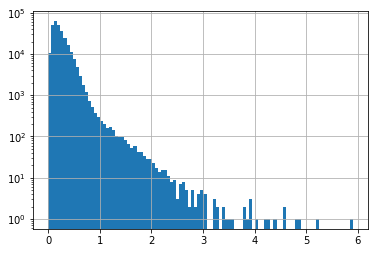

In [88]:
(sonic['diff_mean_sq'].transform(np.sqrt) / sonic['mean']).hist(bins=100, log=True)

In [ ]:
plt.figure(figsize=(20,8))
plt.imshow(s119.groupby([(s119.index.hour * 60 + s119.index.minute)/60, (s119.index.dayofyear)])['unrec_30s_ke_frac'].mean().transform(np.log10).unstack())
plt.xlabel('Day of Year')
plt.ylabel('10-minute record of day')
plt.title('log(Unrecoverable Energy FRACTION): 30 second cutoff')
plt.show()

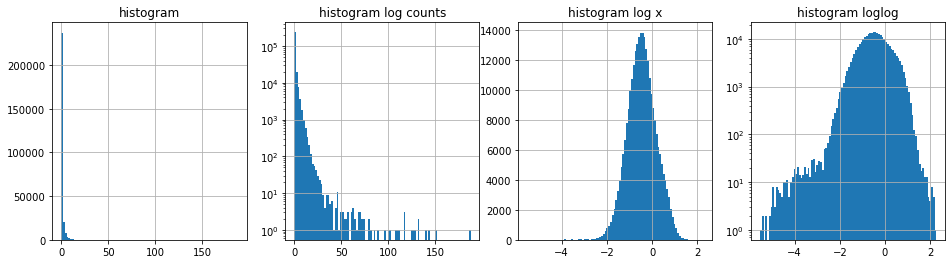

In [9]:
fig, axs = plt.subplots(1,4, figsize=(16,4))
sonic['cum_square_sd_30s'].hist(bins=100, ax=axs[0])
axs[0].set_title('histogram')
sonic['cum_square_sd_30s'].hist(bins=100, log=True, ax=axs[1])
axs[1].set_title('histogram log counts')
sonic['cum_square_sd_30s'].transform(np.log10).hist(bins=100, log=False, ax=axs[2])
axs[2].set_title('histogram log x')
sonic['cum_square_sd_30s'].transform(np.log10).hist(bins=100, log=True, ax=axs[3])
axs[3].set_title('histogram loglog')
plt.show()

**Also want to verify this is true for each sensor individually, not just in aggregate:**

seaborn ecdf plot is bugged

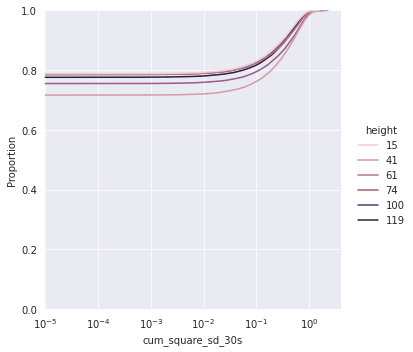

In [115]:
sns.displot(data=sonic, x='cum_square_sd_30s', hue='height', log_scale=True, kind='ecdf')

In [11]:
def log_ecdf(series: pd.Series, ax, label, logx=False, **kwargs):
    sorted_ = series.sort_values()
    ranks = sorted_.rank(pct=True)
    if logx:
        sorted_ = np.log10(sorted_)
    ax.plot(sorted_, ranks, label=label, **kwargs)

Looks fine to me:

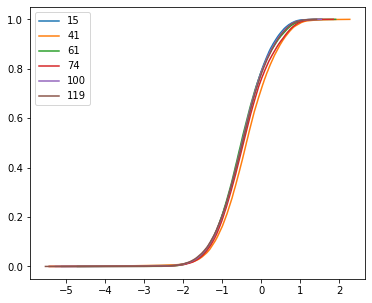

In [12]:
fig, ax = plt.subplots(figsize=(6,5))
grouped = sonic.groupby('height')
for name, grp in grouped:
    log_ecdf(grp['cum_square_sd_30s'], ax, name, logx=True)
ax.legend()

#### Multi-modal Max is due to hitting ceiling of sensor range
Plotting across individual instruments shows this is a universal phenomenon.

With higher bin resolution, can clearly see this is a non-physical artifact. Also note spike of 0 values on height 61.

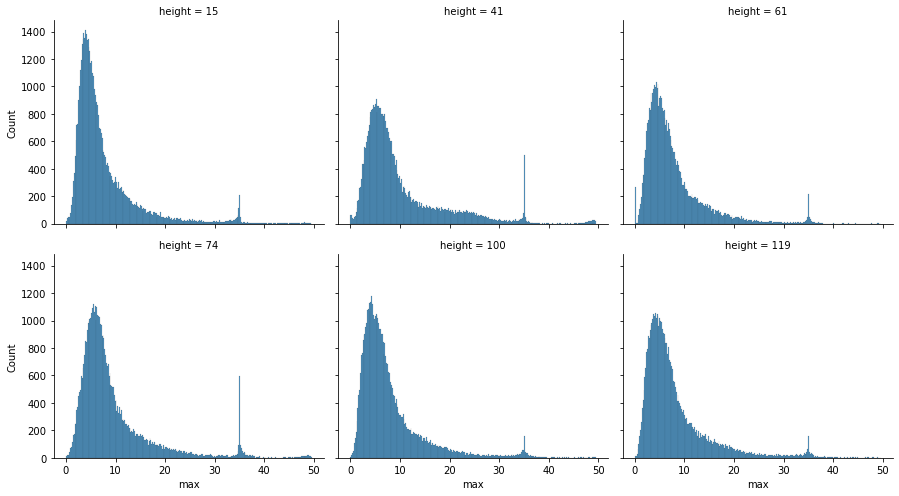

In [76]:
sns.displot(data=sonic, x='max', col='height', col_wrap=3, kind='hist', height=3.5, aspect=1.2)

My instincts said this was a thresholding issue due to the 'pile-up' of counts at a single value in the tail of a distribution. "Wouldn't a threshold have zero counts beyond the threshold?" Important context here is that sensors measure wind speed in 3 components (x, y, z), and horizontal wind speed (seen here) is a combination of x and y via pythagoras. This gives opportunity for multiple artifacts.

My hypothesis is that the erroneous peak at 35 is due to a component-wise threshold on windspeed. I further hypothesize that the second, much smaller peak just under 50 is actually located at sqrt(35^2 + 35^2), produced when both components are capped.

In [78]:
(35 **2 + 35 **2) ** 0.5

49.49747468305833

In [77]:
sonic.groupby('height')['max'].max()

height
15     49.377583
41     49.554045
61     49.080979
74     49.469198
100    49.546973
119    49.497507
Name: max, dtype: float64

That's pretty strong evidence for a component-wise ceiling, I think. I'm willing to overlook the slight variation around these numbers due to differences in sensor calibration.

Consulting the data documentation confirms a cap, but not quite at that value. This strengthens my confidence that there is a threshold, but undermines confidence that the documentation is accurate. A quick google of the manufacturer spec sheet also shows 30m/s cap. Maybe this isnt the instrument that's actually on the tower? I trust the histogram more than whatever was typed into that table.
![image located at ../references/sensor_range_from_docs.png](../references/sensor_range_from_docs.png)

**I'll confirm that the raw components are capped at 35.**

First, I filter for high aggregate wind speeds (without lots of missing data). Then, I open the corresponding raw data files and examine the raw components.

In [11]:
big_max = sonic.query('max > 40 & nan_count < 100').sample(5, random_state=0)
big_max[['timestamp', 'mean', 'min', 'max']]

timestamp       mean       min        max
288090 2019-11-30 03:30:00  19.034376  6.339669  43.062495
288150 2019-11-30 05:10:00  19.711045  5.772495  41.217512
288030 2019-11-30 01:50:00  21.231343  7.027012  44.431817
288025 2019-11-30 01:40:00  24.879892  9.659917  41.678832
287964 2019-11-30 00:00:00  20.190382  7.610000  46.742812

In [14]:
folder = Path('../data/raw/')
fig, axs = plt.subplots(len(big_max), 2, figsize=(12,20))

for i, row in enumerate(big_max.iterrows()):
    raw_filename = (row[1]['timestamp'] + pd.Timedelta('7h')).strftime("%m_%d_%Y_%H_%M_%S_000.mat")
    height = row[1]['height']
    cols = [f'Sonic_x_clean_{height}m', f'Sonic_y_clean_{height}m', f'Sonic_x_{height}', f'Sonic_y_{height}', f'Sonic_CupEqHorizSpeed_{height}m']
    
    raw_data = pmat.matlab_to_pandas(folder / raw_filename, col_subset=cols)
    for n in range(2):
        raw_data[cols[n]].hist(bins=100, ax=axs[i,n], label=cols[n])
        axs[i,n].legend()
    
    axs[i,0].set_title(raw_filename)

In [35]:
pd.concat(component_maxes)

Sonic_x_clean_15m    35.05
Sonic_y_clean_15m    30.15
Sonic_x_clean_15m    34.38
Sonic_y_clean_15m    29.98
Sonic_x_clean_15m    34.14
Sonic_y_clean_15m     8.34
Sonic_x_clean_15m    35.04
Sonic_y_clean_15m    30.17
Sonic_x_clean_15m    34.86
Sonic_y_clean_15m    31.40
dtype: float64

It is quite suspicious that neither x nor y ever exceed 35.05

As always, answering one question leads to 5 more. **How much can I really trust the NREL cleaning?** To get a better sense of this, I'll examine raw vs cleaned data and get a basic understanding of what they do to the data.

Next, I check scatter plots of raw vs clean data below. They suggest that nearly the entire difference between them is high speed clipping. NREL unfortunately does not make their cleaning scripts public, but in the docs, I do see mention of linear interpolation, which could be responsible for the scatter of clipped values (not just clamped to 35, but interpolated between adjacent points < 35).

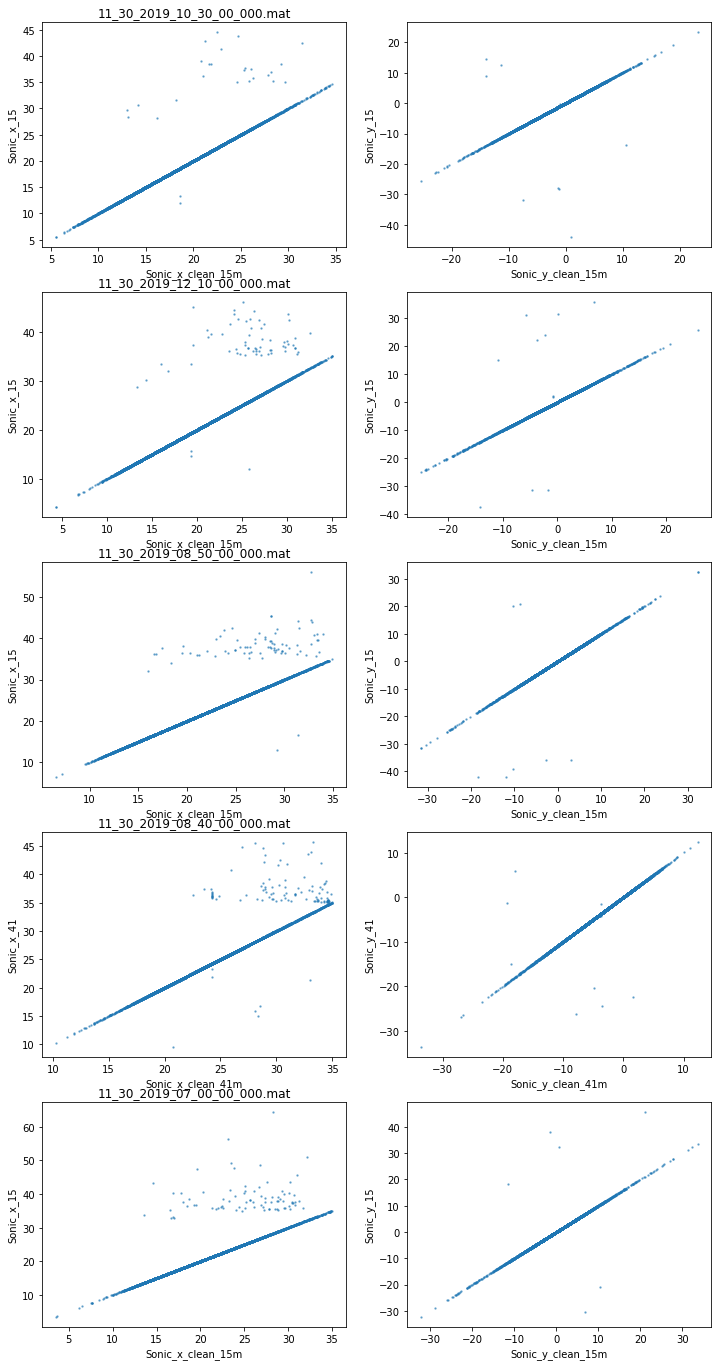

In [36]:
folder = Path('../data/raw/')
fig, axs = plt.subplots(len(big_max), 2, figsize=(12,24))

for i, row in enumerate(big_max.iterrows()):
    raw_filename = (row[1]['timestamp'] + pd.Timedelta('7h')).strftime("%m_%d_%Y_%H_%M_%S_000.mat")
    height = row[1]['height']
    cols = [f'Sonic_x_clean_{height}m', f'Sonic_y_clean_{height}m', f'Sonic_x_{height}', f'Sonic_y_{height}', 'time_UTC', f'Sonic_CupEqHorizSpeed_{height}m']
    
    raw_data = pmat.matlab_to_pandas(folder / raw_filename, col_subset=cols).drop(columns=['time_UTC'])
    raw_data.plot.scatter(x=cols[0], y=cols[2], s=2, alpha=0.5, ax=axs[i,0])
    raw_data.plot.scatter(x=cols[1], y=cols[3], s=2, alpha=0.5, ax=axs[i,1])
    axs[i,0].set_title(raw_filename)

Plotting timeseries of raw vs clean vs magnitude below shows a few things:
1. When raw data crosses 35 m/s, the corresponding clean data point is filtered out and linearly interpolated
1. When raw data has a large enough spike, even if it doesn't cross 35 m/s, the corresponding clean data point is filtered out and linearly interpolated. NREL seems to think they are erroneous (else why would they clean them out) and I don't know enough to disagree.
1. velocity magnitude (CupEqHorizSpeed) has different filters than the clean data. It includes spikes, but only if the spike didn't pass the arbitrary 35 m/s threshold.
1. velocity magnitude is not linearly interpolated. nan values are left in.

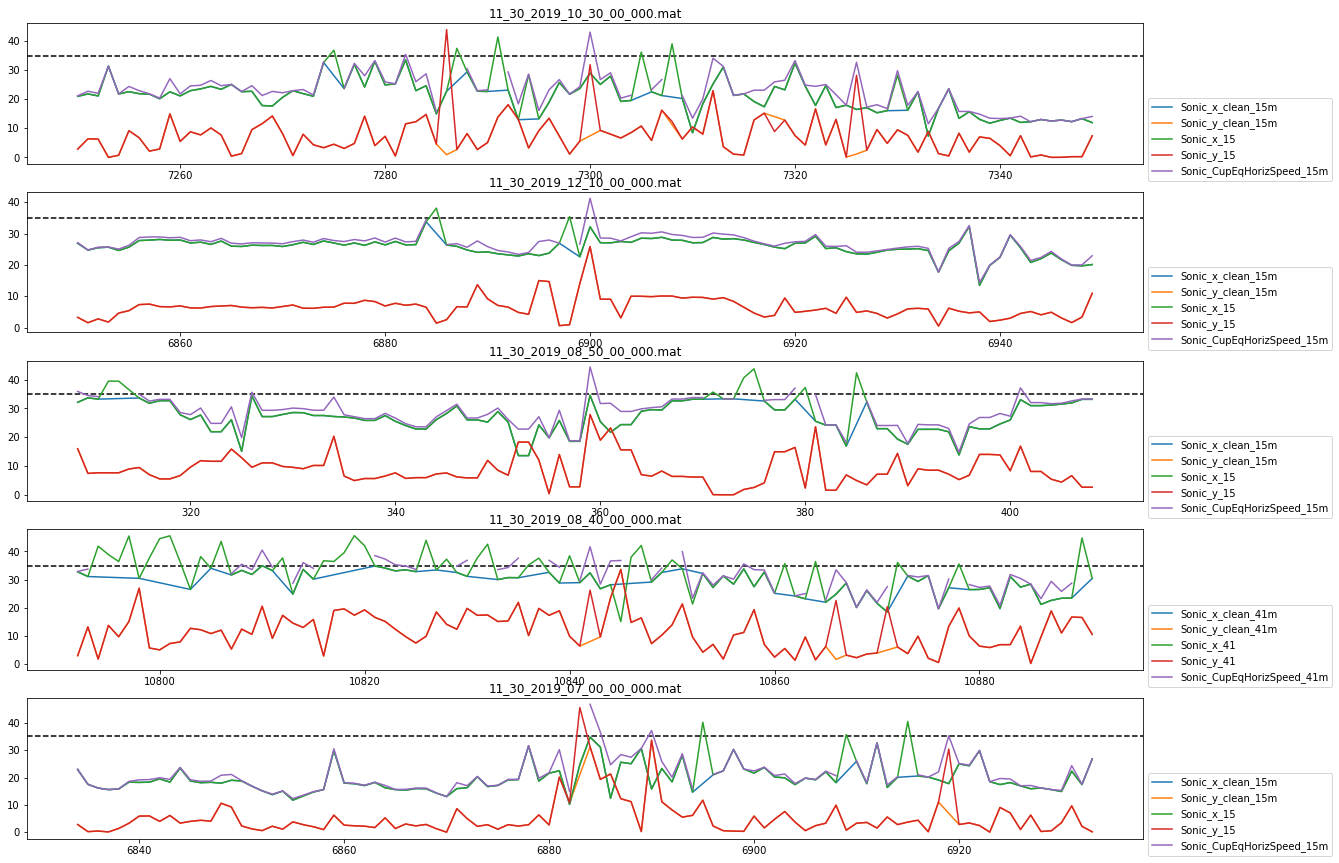

In [24]:
folder = Path('../data/raw/')
fig, axs = plt.subplots(len(big_max), figsize=(20,15))
component_maxes = []

for i, row in enumerate(big_max.iterrows()):
    raw_filename = (row[1]['timestamp'] + pd.Timedelta('7h')).strftime("%m_%d_%Y_%H_%M_%S_000.mat")
    height = row[1]['height']
    cols = [f'Sonic_x_clean_{height}m', f'Sonic_y_clean_{height}m', f'Sonic_x_{height}', f'Sonic_y_{height}', 'time_UTC', f'Sonic_CupEqHorizSpeed_{height}m']
    
    raw_data = pmat.matlab_to_pandas(folder / raw_filename, col_subset=cols)
    component_maxes.append(raw_data[cols[:2]].max())
    
    max_loc = raw_data[cols[-1]].argmax()
    
    axs[i].axhline(35, c='k', linestyle='--')
    raw_data.iloc[max(0, max_loc - 50): min(11999, max_loc + 50),:].abs().plot(ax=axs[i]).legend(bbox_to_anchor=(1, 0.5))
    axs[i].set_title(raw_filename)

This dataset contains multiple sensors, one at each height. Some problems (like with data collection) effect all sensors simultaneously. These are high-impact issues, so I'll check those first.

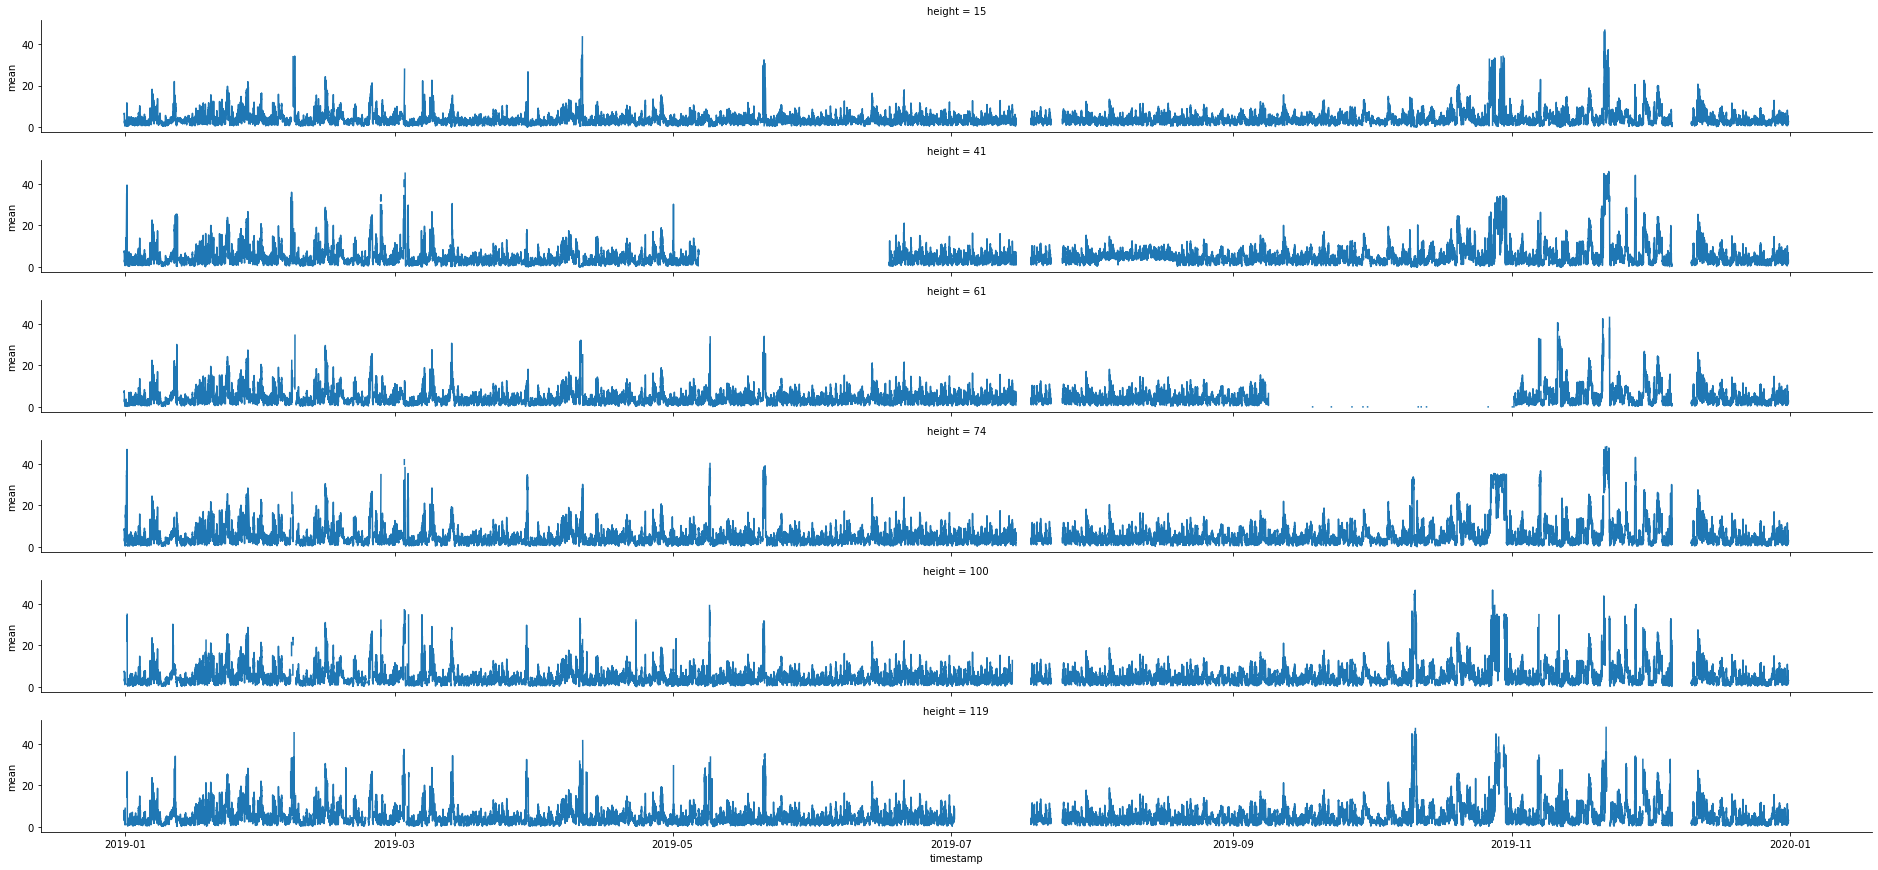

In [37]:
sns.relplot(data=sonic, x='timestamp', y='mean', row='height', kind='line', height=2, aspect=13)

Also, height 41, in August, looks like it had some kind of step change no other series had. I'll check for other correlation changes in time.

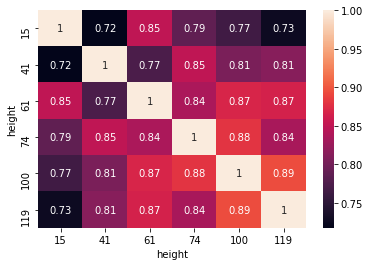

In [45]:
# all-time correlation matrix of mean by height
# expect heights to correlate better to closer neighbors
sns.heatmap(sonic.pivot(index='timestamp', columns='height', values='mean').corr(), annot=True)
plt.show()

To check correlation over time, I'll plot rolling pearson correlation. Heights 74 and 100 have the best coverage, so I'll use one of them a a benchmark, then check vs the other.

In [50]:
sonic.pivot(index='timestamp', columns='height', values='mean').head(3)

height                    15        41        61        74        100  \
timestamp                                                               
2018-12-31 17:00:00  6.392259  7.187378  7.279952  8.192143  7.341598   
2018-12-31 17:10:00  6.597348  7.154021  7.041983  7.849541  6.816752   
2018-12-31 17:20:00  6.491059  7.727798  7.754189  8.696105  7.504780   

height                    119  
timestamp                      
2018-12-31 17:00:00  7.741269  
2018-12-31 17:10:00  7.233263  
2018-12-31 17:20:00  7.899411

In [126]:
window_days = 30
coverage_threshold = 0.9
roll_corr = sonic.pivot(index='timestamp', columns='height', values='mean').rolling(str(window_days) +'d', min_periods=int(6*24*window_days * coverage_threshold)).corr().unstack().dropna(how='all')
roll_corr.head(3)

height               15                                        41        \
height               15        41        61  74  100 119       15   41    
timestamp                                                                 
2019-01-27 17:00:00  1.0       NaN       NaN NaN NaN NaN       NaN  NaN   
2019-01-27 17:10:00  1.0       NaN  0.928247 NaN NaN NaN       NaN  1.0   
2019-01-27 17:20:00  1.0  0.818033  0.928249 NaN NaN NaN  0.818033  1.0   

height                             ... 100             119                      
height                    61  74   ... 61  74  100 119 15  41  61  74  100 119  
timestamp                          ...                                          
2019-01-27 17:00:00       NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2019-01-27 17:10:00       NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2019-01-27 17:20:00  0.797253 NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[3 rows x 36 columns]

In [127]:
roll_corr.columns.rename(['height1', 'height2'], inplace=True)

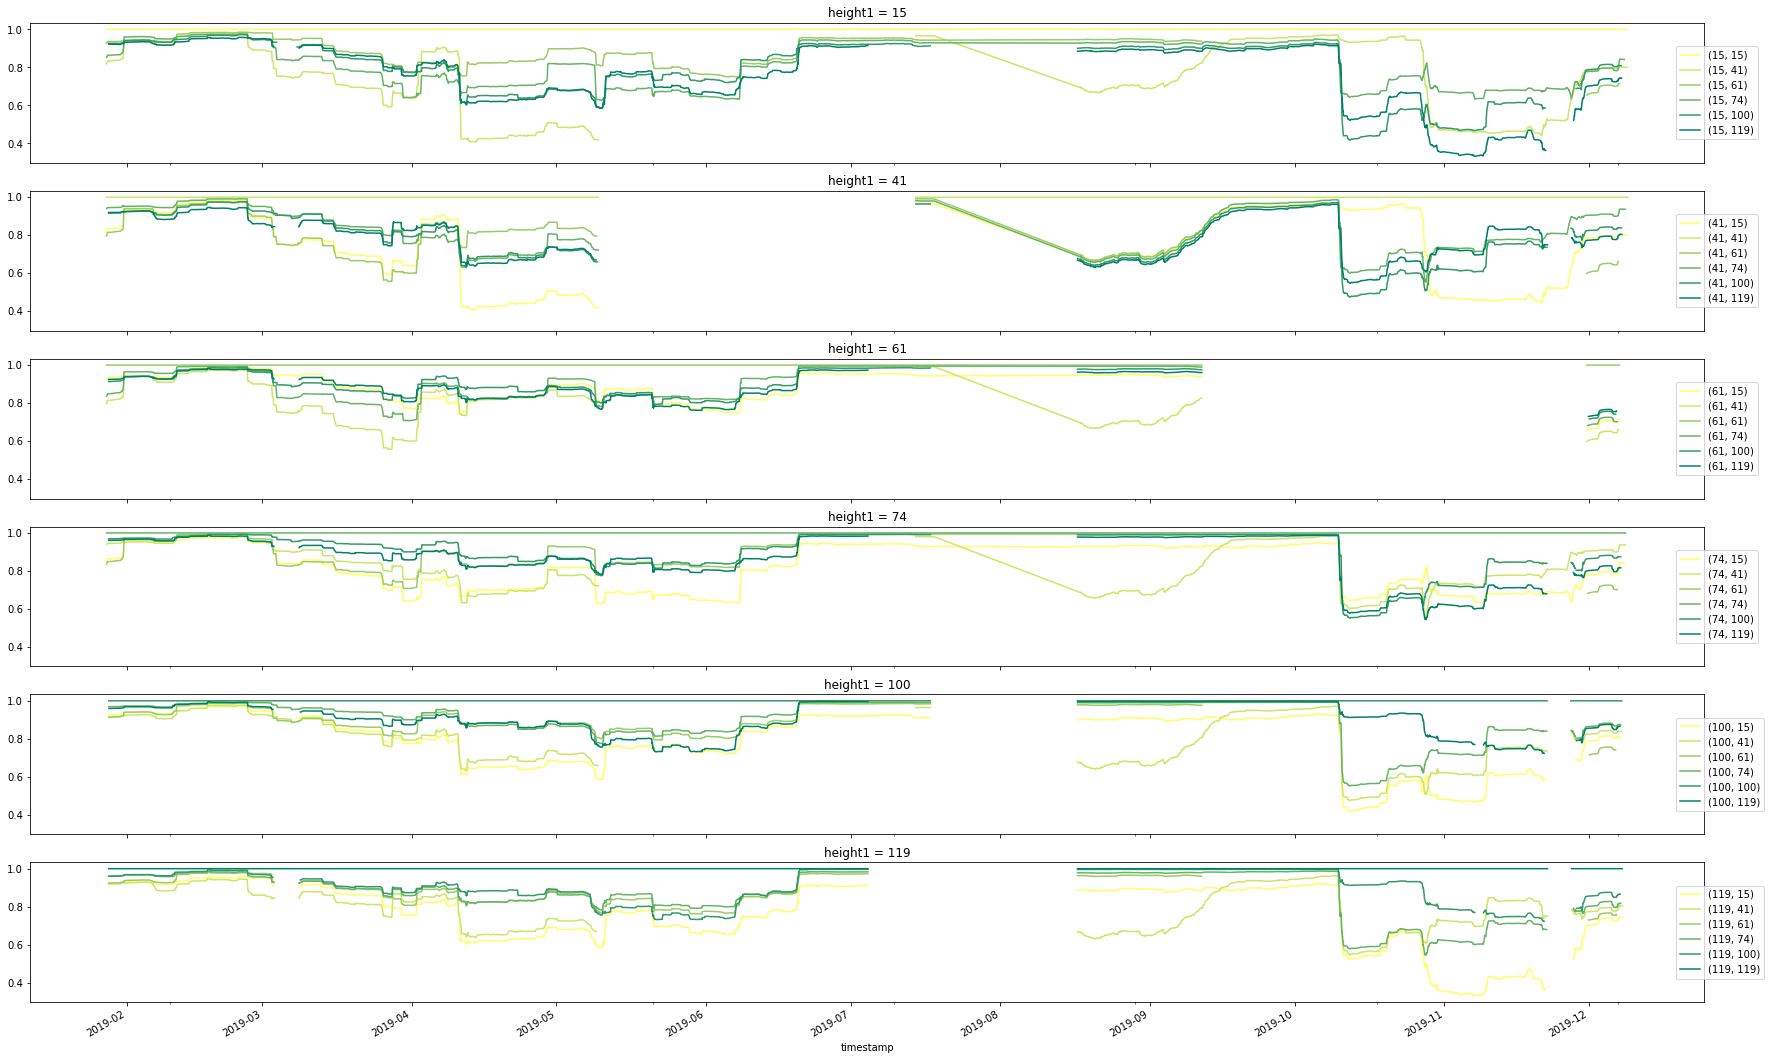

In [149]:
fig, axs = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(30,20))
for i, height in enumerate(roll_corr.columns.get_level_values(level=0).unique()):
    roll_corr.loc[:, pd.IndexSlice[height, :]].plot(ax=axs[i], legend=False, cmap='cividis')
    axs[i].set_title(f'height1 = {height}')
    axs[i].legend(loc='center left', bbox_to_anchor=(0.98, 0.5))
plt.show()

In [123]:
roll_corr = roll_corr.unstack().rename('corr').reset_index()
roll_corr.head(3)

height1  height2           timestamp  corr
0       15       15 2019-01-27 17:00:00   1.0
1       15       15 2019-01-27 17:10:00   1.0
2       15       15 2019-01-27 17:20:00   1.0

In [124]:
sns.relplot(data=roll_corr, x='timestamp', y='corr', kind='line', hue='height2', row='height1', height=2.5, aspect=11)

In [25]:
heights = sonic['height'].unique()
heights

array([ 15,  41,  61,  74, 100, 119])

In [28]:
height=41
cols = [f'Sonic_x_clean_{height}m', f'Sonic_y_clean_{height}m', f'Sonic_x_{height}', f'Sonic_y_{height}', f'Sonic_CupEqHorizSpeed_{height}m']
raw_df = pmat.matlab_to_pandas(folder / '09_30_2019_08_40_00_000.mat', col_subset=cols)
raw_df.head()

Sonic_x_clean_41m  Sonic_y_clean_41m  Sonic_x_41  Sonic_y_41  \
0               4.63              -2.97        4.63       -2.97   
1               4.69              -3.07        4.69       -3.07   
2               4.77              -3.09        4.77       -3.09   
3               4.78              -3.13        4.78       -3.13   
4               4.69              -3.08        4.69       -3.08   

   Sonic_CupEqHorizSpeed_41m  
0                   5.500709  
1                   5.605444  
2                   5.683397  
3                   5.713607  
4                   5.610927

In [29]:
# product of consecutive differences - single-point spikes (up or down) will be large and negative
raw_df['diff_product'] = raw_df['Sonic_x_41'].diff(1) * -1 * raw_df['Sonic_x_41'].diff(-1)
raw_df['diff_product'].hist(bins=100, log=True)

In [30]:
raw_df['diff_product'].describe()

count    11998.000000
mean        -0.018272
std          0.555704
min        -24.763200
25%         -0.016800
50%          0.000000
75%          0.015600
max          3.873400
Name: diff_product, dtype: float64

In [31]:
max_loc = raw_df['diff_product'].idxmin()
raw_df.iloc[max(0, max_loc - 50): min(11999, max_loc + 50), :-1].abs().plot(figsize=(12,5)).legend(bbox_to_anchor=(1, 0.5))

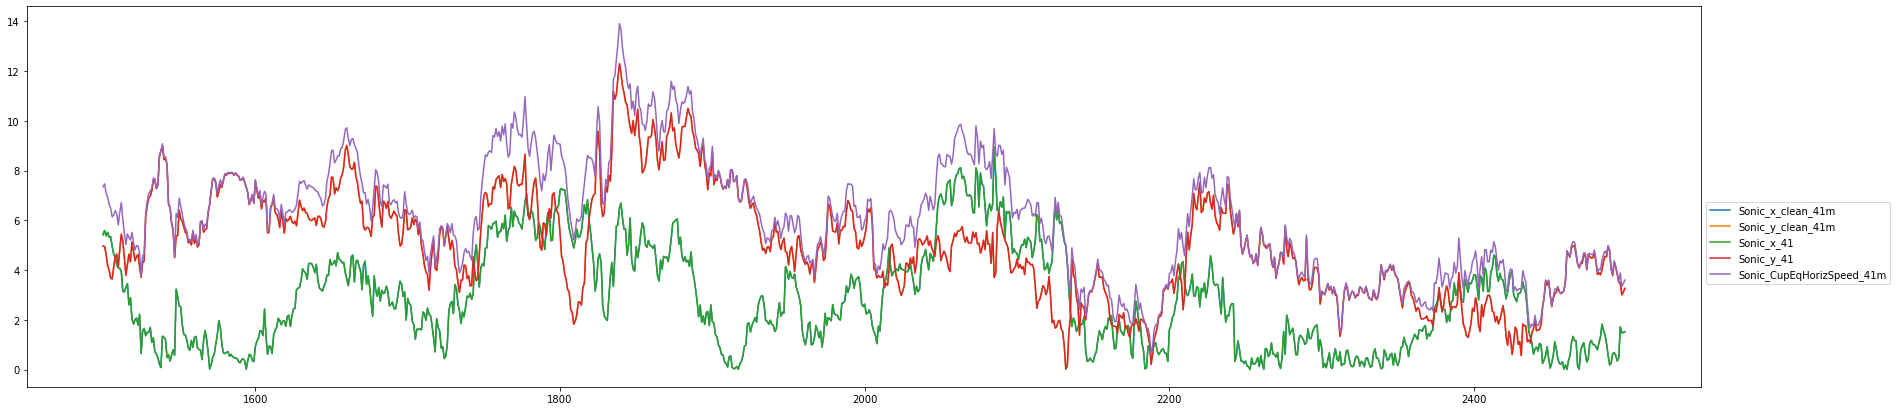

In [32]:
raw_df.iloc[1500:2500, :-1].abs().plot(figsize=(30,7)).legend(bbox_to_anchor=(1, 0.5))

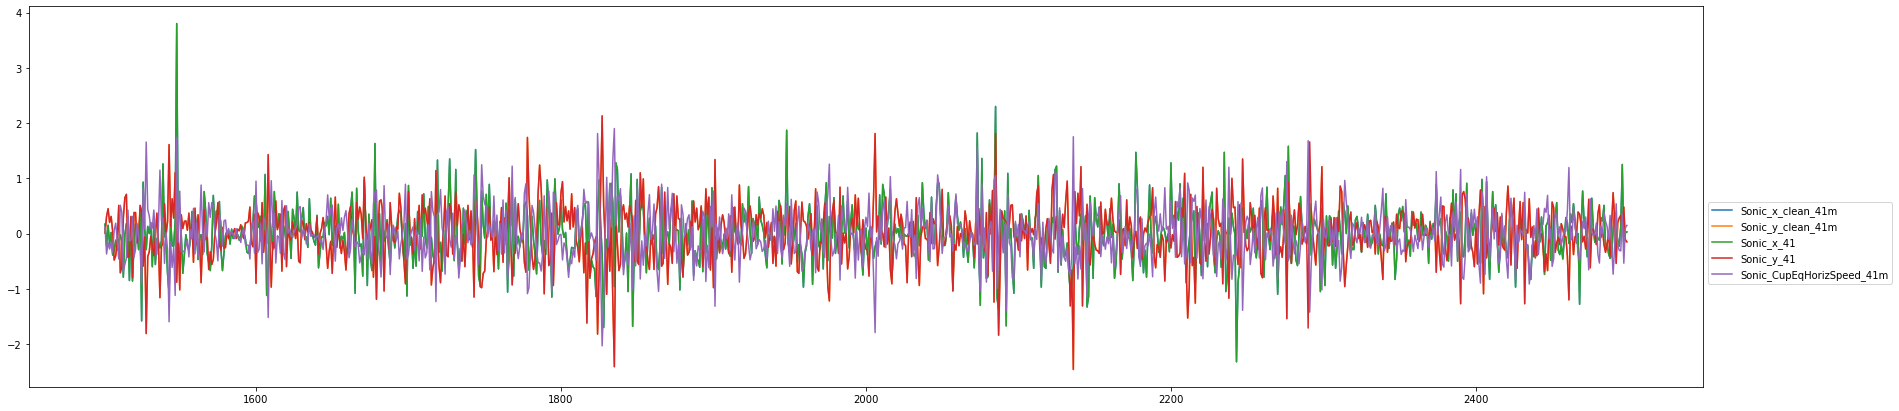

In [33]:
raw_df.iloc[1500:2500, :-1].diff().plot(figsize=(30,7)).legend(bbox_to_anchor=(1, 0.5))

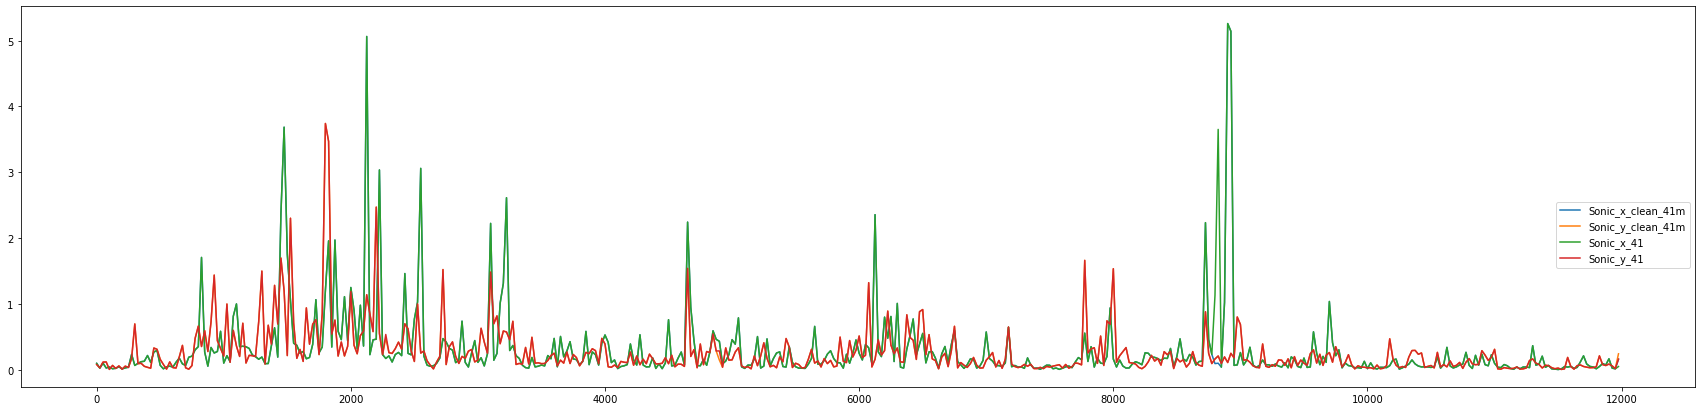

In [34]:
bin_index = (raw_df.index // 25).astype(int) * 25
raw_df.iloc[:,:4].groupby(bin_index).var().plot(figsize=(30,7)).legend(bbox_to_anchor=(1, 0.5))

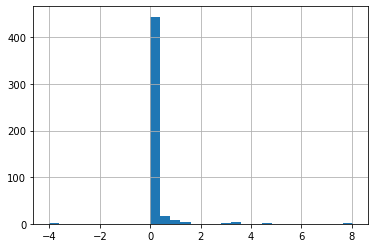

In [35]:
binned = raw_df.iloc[:,2].groupby(bin_index).agg(['std', 'mean'])
(binned['std'] / binned['mean']).hist(bins=30)

In [36]:
def load_inst(inst: str, timestamp: pd.Timestamp, src_folder: Path):
    fname = aggr.matlab_filename_from_timestamp(timestamp)
    return pmat.matlab_to_pandas(src_folder / fname, col_subset=[inst])

In [37]:
def iqr_norm(series: pd.Series) -> pd.Series:
    # HACK TO TEST. ACtual IQR norm is commented out below
    iqr = (series - series.median()).abs().median() / np.log(2)
    return series / iqr

'''
def iqr_norm(series: pd.Series) -> pd.Series:
    iqr = series.quantile([0.25, 0.75]).diff().iloc[-1]
    return series / iqr
'''

def spike_score(series: pd.Series) -> pd.Series:
    """Signed square root of the product of consecutive differences. Spikes are large, negative values."""
    diff_prod = series.diff(1) * -1 * series.diff(-1)
    return np.sign(diff_prod) * np.sqrt(diff_prod.abs()) # sqrt to get back on same scale as diff

In [38]:
from typing import Optional, Dict, List
def viz_series(series: pd.Series, axs: plt.Axes, bins=100, append_to: Optional[Dict] = None, range=None):
    diff = iqr_norm(series.diff())
    spike = iqr_norm(spike_score(series))
    if append_to:
        append_to['diff'].append(diff)
        append_to['spike'].append(spike)
    series.hist(bins=bins, ax=axs[0], label=series.name)
    diff.hist(bins=bins, ax=axs[1], log=True, range=range, label='diff')
    spike.hist(bins=bins, ax=axs[2], log=True, range=range, label='spike_score')
    for ax in axs:
        ax.legend()

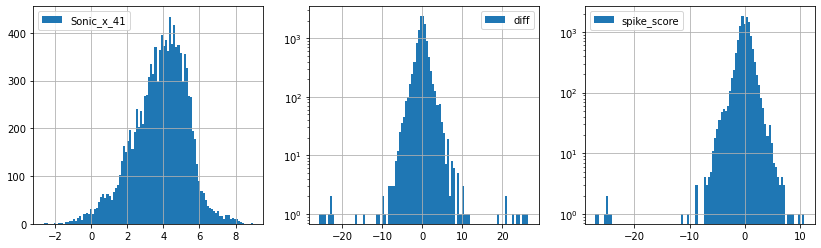

In [39]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
viz_series(raw_df['Sonic_x_41'], axs)

In [40]:
def viz_multiple(series_list: List[pd.Series], range=None):
    n = len(series_list)
    aggregate = {'diff': [],
                 'spike': []}
    
    fig, axs = plt.subplots(n + 1, 3, figsize=(14, (n+1)*4))
    for i, series in enumerate(series_list):
        viz_series(series, axs[i,:], append_to=aggregate, range=range)
    # plot aggregates
    pd.concat(series_list, ignore_index=True).hist(bins=100, ax=axs[n,0], label='combined')
    pd.concat(aggregate['diff'], ignore_index=True).hist(bins=100, ax=axs[n,1], log=True, range=range, label='diff_all')
    pd.concat(aggregate['spike'], ignore_index=True).hist(bins=100, ax=axs[n,2], log=True, range=range, label='spike_all')
    for ax in axs[n,:]:
        ax.legend()

In [43]:
subsample = sonic.query('nan_count < 100').sample(5, random_state=42)
subsample[['timestamp', 'height', 'mean', 'nan_count', 'dir_mean', 'waked_frac', 'min', 'max', 'diff_mean_sq']]

timestamp  height      mean  nan_count    dir_mean  \
26509  2019-01-31 09:20:00      41  3.098527        0.0  134.219687   
62047  2019-03-13 12:30:00      41  0.406225        0.0   14.661230   
65105  2019-03-17 01:20:00     119  5.035389        0.0  358.854331   
192457 2019-08-11 11:00:00      41  6.158264        0.0   97.968824   
297665 2019-12-11 05:20:00     119  2.544389        0.0  113.212992   

        waked_frac       min        max  diff_mean_sq  
26509     1.000000  1.339888   4.463631      0.273644  
62047     0.070583  0.000000   2.870157      0.108657  
65105     0.000000  4.261842   5.872410      0.090302  
192457    0.860667  0.380000  24.877108     15.112689  
297665    1.000000  0.633482   3.924589      0.517769

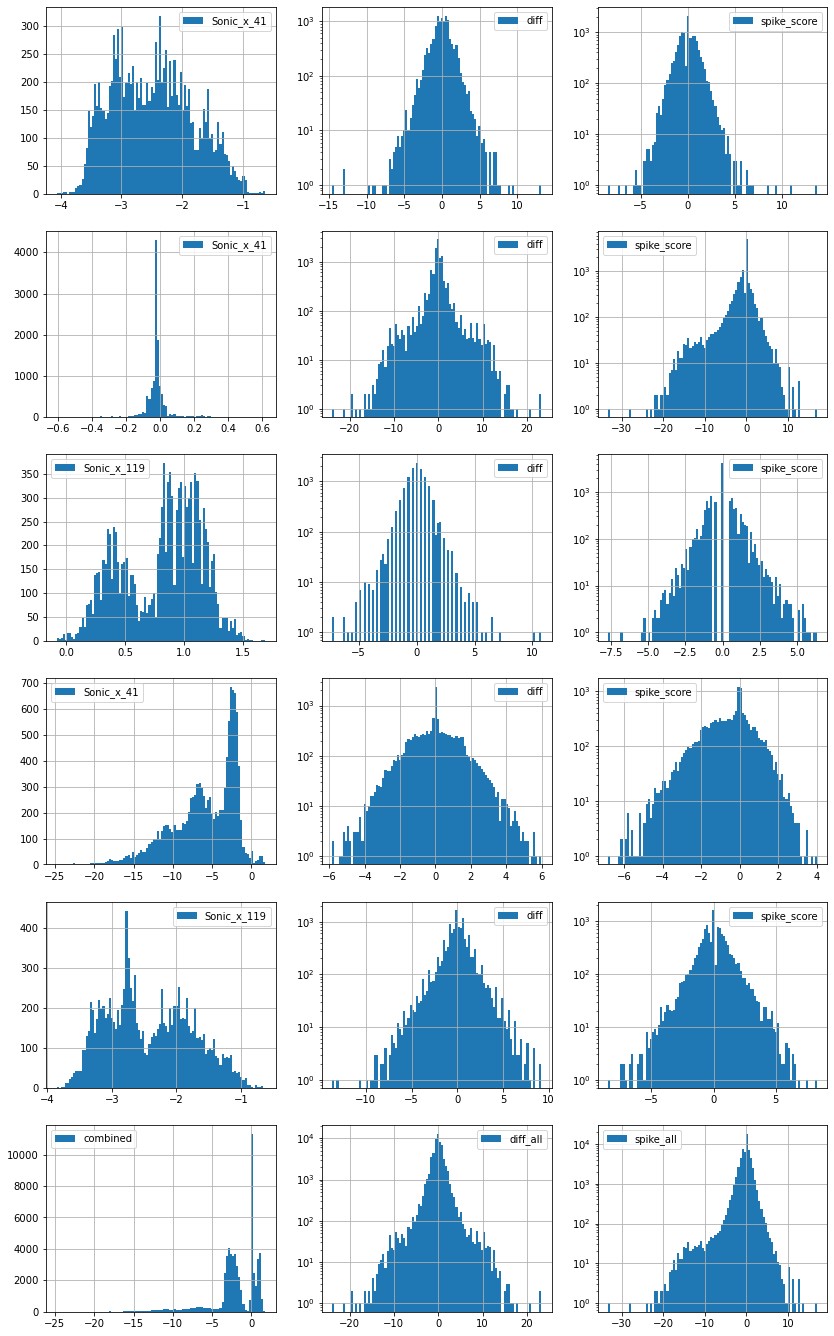

In [44]:
dfs = [load_inst(f'Sonic_x_{row[1]["height"]}', row[1]['timestamp'], folder).squeeze() for row in subsample.reset_index().iterrows()]
viz_multiple(dfs)

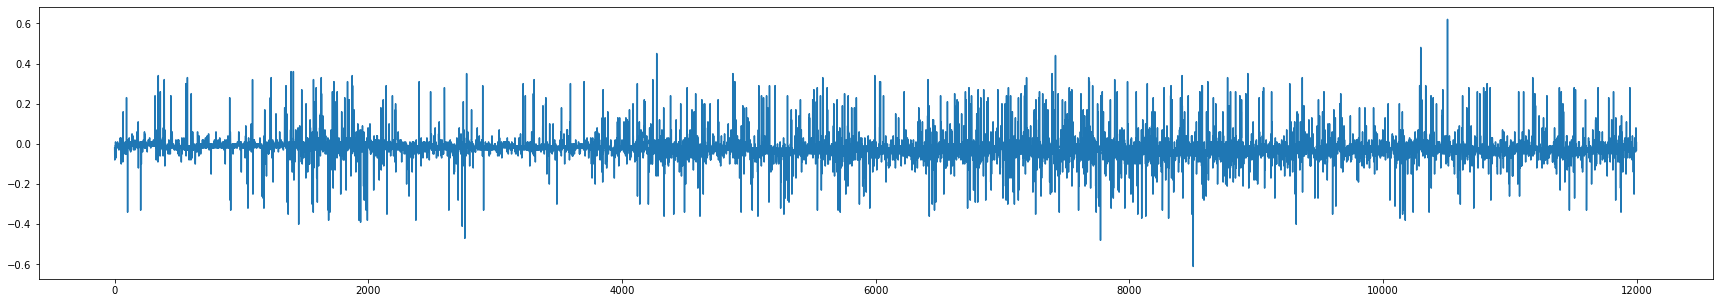

In [80]:
dfs[1].iloc[:].plot(figsize=(30,5))

In [45]:
from scipy.stats.distributions import laplace

In [46]:
sim = laplace.rvs(0,1, size=12000)
loc, scale = laplace.fit(sim)
scale

1.0053537323496364

In [47]:
pd.Series(sim).abs().mean()

1.0052580951215309

In [48]:
x = np.linspace(-7.5, 7.5, 100)
y = laplace.pdf(x, loc=loc, scale=scale)

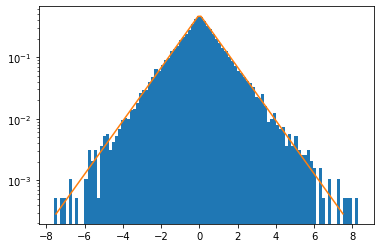

In [49]:
plt.hist(sim, bins=100, log=True, density=True)
plt.plot(x,y)
plt.show()

**Robust method from exponential distribution:**

Abs(centered(laplacian)) = exponential

median of an exponential is ln(2) * scale_param. So solve for scale param. Easy!

In [412]:
x = np.linspace(-7.5 * scale, 7.5 * scale, 3)
y = laplace.pdf(x, loc=0, scale=scale)

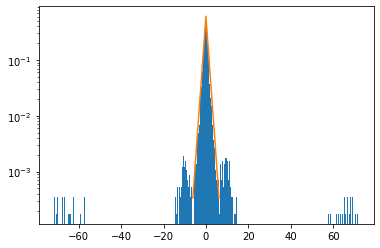

In [417]:
plt.hist(iqr_norm(dfs[0].diff()), bins=300, log=True, density=True)
plt.plot(x,y)
plt.show()

In [65]:
def plot_laplace_fit(data, ax):
    mean = data.mean()
    median = data.median()
    mle_scale = (data - mean).abs().mean()
    robust_scale = (data - median).abs().median() / np.log(2)
    x = np.linspace(-7.5 * mle_scale, 7.5 * mle_scale, 3)
    y = laplace.pdf(x, loc=mean, scale=mle_scale)
    y_robust = laplace.pdf(x, loc=median, scale=robust_scale)
    ax.hist(data, bins=200, log=True, density=True)
    ax.plot(x,y, label=f'MLE={mle_scale:.4f}')
    ax.plot(x,y_robust, label=f'robust={robust_scale:.4f}')
    plt.legend()

/home/tpb/miniconda3/envs/turbulence/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tpb/miniconda3/envs/turbulence/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


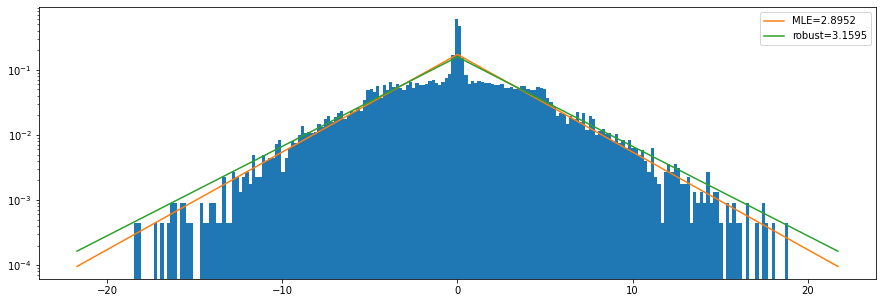

In [70]:
_, ax = plt.subplots(figsize=(15,5))
plot_laplace_fit(dfs[3].diff(), ax)
plt.show()

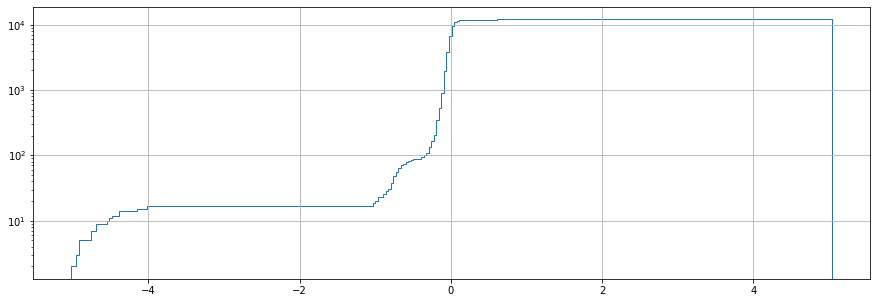

In [405]:
dfs[0].diff().hist(bins=300, log=True, cumulative=True, figsize=(15,5), histtype='step')

In [7]:
s119 = sonic.query('height == 119').drop(columns='height').set_index('timestamp', drop=True)
s119.head(3)

nan_count      mean  diff_mean_sq  diff_mean_cube  \
timestamp                                                                
2018-12-31 17:00:00          0  7.741269      0.278593        6.444512   
2018-12-31 17:10:00          0  7.233263      0.477996       10.375038   
2018-12-31 17:20:00          0  7.899411      0.279826        6.436817   

                     cum_square_sd_60s  cum_square_sd_30s  cum_square_sd_10s  \
timestamp                                                                      
2018-12-31 17:00:00           0.175206           0.221440           0.249491   
2018-12-31 17:10:00           0.373757           0.418074           0.445737   
2018-12-31 17:20:00           0.173689           0.219780           0.251649   

                     cum_square_sd_2s  cum_cube_sd_60s  cum_cube_sd_30s  ...  \
timestamp                                                                ...   
2018-12-31 17:00:00          0.270052         6.103863         6.372773  ...   
2018-12-31 17:10:00          0.466931        10.097132        10.295073  ...   
2018-12-31 17:20:00          0.270449         6.068854         6.338365  ...   

                     vert_nan_count  vert_mean  vert_mean_square  \
timestamp                                                          
2018-12-31 17:00:00               0  -0.116775          0.103902   
2018-12-31 17:10:00               0  -0.133584          0.157386   
2018-12-31 17:20:00               0  -0.163695          0.103526   

                     vert_mean_cube  vert_cum_square_sd_60s  \
timestamp                                                     
2018-12-31 17:00:00       -0.007359                0.018279   
2018-12-31 17:10:00       -0.025958                0.040330   
2018-12-31 17:20:00       -0.033056                0.016517   

                     vert_cum_square_sd_30s  vert_cum_square_sd_10s  \
timestamp                                                             
2018-12-31 17:00:00                0.034086                0.060655   
2018-12-31 17:10:00                0.063172                0.104504   
2018-12-31 17:20:00                0.029382                0.051968   

                     vert_cum_square_sd_2s   dir_mean  waked_frac  
timestamp                                                          
2018-12-31 17:00:00               0.080494  22.387435         0.0  
2018-12-31 17:10:00               0.128307  18.884868         0.0  
2018-12-31 17:20:00               0.068729  19.204617         0.0  

[3 rows x 22 columns]

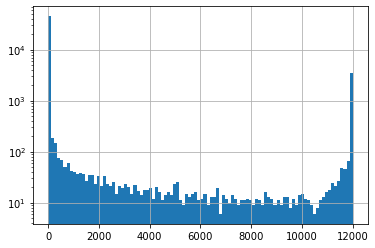

In [8]:
s119['nan_count'].hist(bins=100, log=True)

The following plot shows the fraction of aggreagted nan values when the raw data contains at least one nan. Surprisingly, some 60% of records-with-nan don't even have a mean value.

In [21]:
# 58% of records with any nans are entirely nan
sonic.query('nan_count == 12000').shape[0] / sonic.query('nan_count > 0').shape[0]

0.576668653158522

In [127]:
sonic.query('nan_count > 0').isna().mean().plot.bar()

In [107]:
sonic['log_var'] = sonic['diff_mean_sq'].replace(0, np.nan).transform(np.log10)

In [112]:
sns.set_style("darkgrid")

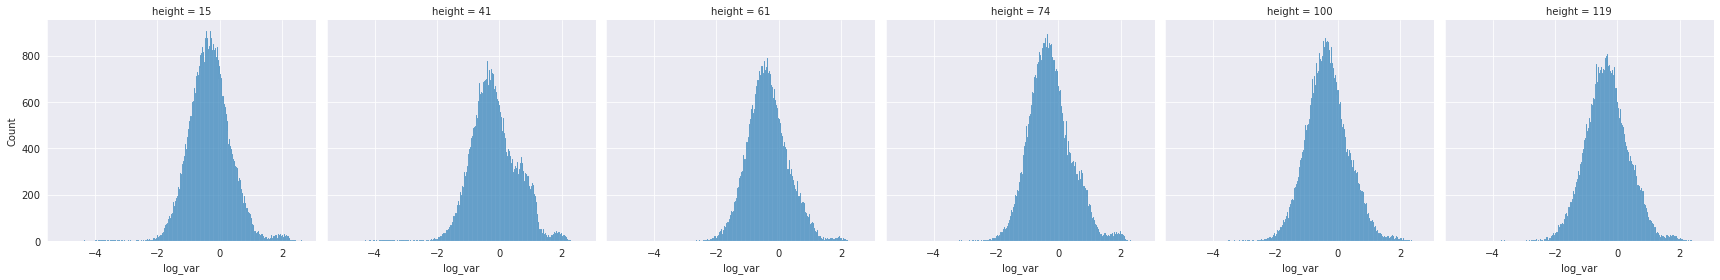

In [114]:
sns.displot(data=sonic, x='log_var', col='height', height=4, aspect=1)

In [121]:
subset = ['timestamp', 'nan_count', 'mean', 'diff_mean_sq', 'cum_square_sd_30s',
          'dir_mean', 'waked_frac', 'min', 'max', '3s_gust', 'log_var']

In [122]:
s74 = sonic.query("height == 74")[subset].copy()
s74['high_var'] = s74['log_var'] > 1.25
s74['ti_sq'] = s74['diff_mean_sq'] / s74['mean'].pow(2)

In [131]:
s74['rec_of_day'] = (s74['timestamp'].dt.minute / 10 + s74['timestamp'].dt.hour * 6).astype(np.uint8)

In [134]:
s74['day_of_year'] = s74['timestamp'].dt.dayofyear.astype(np.uint16)

In [137]:
plt.figure(figsize=(15,6))
plt.imshow(s74.pivot(columns='day_of_year', index='rec_of_day', values='high_var'))

In [ ]:
sns.catplot()